In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Bayesian Optimization with Context Features

In this example we add context features to the approach in the Bayesian Optimization notebook. Again we're using a synthetic example.

## A synthetic example

We add a second parameter y to the function from the Bayesian Optimization notebook.
As before, if we actually had access to the function, we could use more efficient techniques using calculus and would not be using Bayesian Optimization.
We assume that the parameter y is **context** that we can't influence, and that's given to us. This could be hardware properties of the machine we are running on, or properties of the workload. We want to find a parameter x that gives us the best function value (say runtime) given a particular y (e.g. a workload).

In [2]:
# define fake performance function
# In an actual application, we would not have access to this function directly.
# Instead, we could only measure the outcome by running an experiment, such as timing
# a particular run of the system.
# y is "context" such as a property of the workload or the machine
def f(x, y):
    return (6*x-2)**2*np.sin(12*(x * y)-4)

In a real use case for global optimization, the function we want to optimize is usually only implicitly defined and very expensive to compute, such as training and evaluating a neural network, or timing the run of a large workload on a distributed database. Given the cost of evaluating the function, our goal is to find an optimum while keeping the number of function evaluations to a minimum.

In this synthetic example, we actually know the function, so we can just plot it for illustration purposes:

In [3]:
line2 = np.linspace(-1, 1)
line = np.linspace(0, 1)
a, b = np.meshgrid(line, line2)

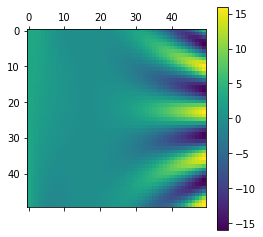

In [4]:
plt.matshow(f(a, b))
plt.colorbar()

It might be easier to think of this as a family of functions, parametrized by `y`. So for each value of `y` we have a 1d function:

Text(0, 0.5, 'Objective (i.e. performance)')

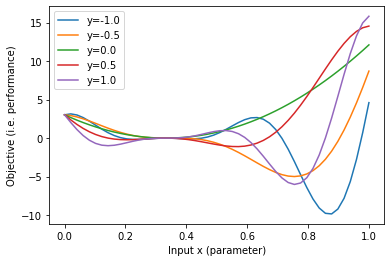

In [5]:
for y in np.linspace(-1, 1, 5):
    plt.plot(line, f(line, y), label=f"y={y}")
    plt.legend()
plt.xlabel("Input x (parameter)")
plt.ylabel("Objective (i.e. performance)")

You can see that depending on the choice of `y`, the optimum for `x` is in different locations. For y=-1 it is around 0.85, while for y=0 it's around 0.35.

Our goal here is to find the global minimum of this function for any `y` that is given, assuming that we don't have direct access to the formula (given the formula, we could instead calculate the optimum quite precicely using methods from calculus instead). Usually, the function is too expensive to evaluate in such a manner, in particular in higher-dimensional spaces.

Now, we use MLOS to construct an OptimizationProblem object that will encapsulate the function and the input space.

In [6]:
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Optimizers.BayesianOptimizer import BayesianOptimizer
from mlos.Spaces import SimpleHypergrid, ContinuousDimension

# single continuous input dimension between 0 and 1
input_space = SimpleHypergrid(name="input", dimensions=[ContinuousDimension(name="x", min=0, max=1)])
# define output space, we might not know the exact ranges
output_space = SimpleHypergrid(name="objective",
                               dimensions=[ContinuousDimension(name="function_value", min=-10, max=10)])
# use a context space between -1 and 1
context_space = SimpleHypergrid(name="context", dimensions=[ContinuousDimension(name="y", min=-1, max=1)])

# define optimization problem with input and output space and objective
optimization_problem = OptimizationProblem(
    parameter_space=input_space,
    objective_space=output_space,
    # we want to minimize the function
    objectives=[Objective(name="function_value", minimize=True)],
    context_space=context_space
)

We set up our optimization as before:

In [7]:
from mlos.Optimizers.BayesianOptimizer import BayesianOptimizer, BayesianOptimizerConfig
from mlos.Optimizers.RegressionModels.HomogeneousRandomForestRegressionModel import HomogeneousRandomForestRegressionModelConfig

from mlos.Spaces import Point

optimizer_config = BayesianOptimizerConfig.DEFAULT.copy()
optimizer_config.experiment_designer_config_fraction_random_suggestions = .1
random_forest_config = optimizer_config.homogeneous_random_forest_regression_model_config

random_forest_config.decision_tree_regression_model_config.n_new_samples_before_refit = 1
random_forest_config.decision_tree_regression_model_config.splitter = 'best'
# right now we're sampling without replacement so we need to subsample to make the trees different when using the 'best' splitter
random_forest_config.samples_fraction_per_estimator = .9
random_forest_config.n_estimators = 10

optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha = 0.1

optimizer = BayesianOptimizer(optimization_problem, optimizer_config)

Each suggestion now depends on the context ``y``:

In [8]:
suggested_value = optimizer.suggest(context=Point(y=1))
suggested_value

{'x': 0.7769243401082127}

In [9]:
def run_optimization(optimizer):
    # suggest new value from optimizer
    # we just randomly pick a context y
    # usually these would be specified by the problem,
    # i.e. properties of the workload given by the user
    y = Point(y=np.random.uniform(-1, 1))
    suggested_value = optimizer.suggest(context=y)
    input_values_df = suggested_value.to_dataframe()
    # we add the context to the input_values_df for the optimizer
    input_values_df['y'] = y.y
    # suggested value are dictionary-like, keys are input space parameter names
    # evaluate target function
    target_value = f(suggested_value['x'], input_values_df['y'][0])
    print(suggested_value, target_value)
    
    target_values_df = pd.DataFrame({'function_value': [target_value]})    
    optimizer.register(input_values_df, target_values_df)

# run for some iterations
n_iterations = 15
for i in range(n_iterations):
    run_optimization(optimizer)

{'x': 0.9863131375459547} 4.700598848722243
{'x': 0.5288975237299107} 0.3047122587404516
{'x': 0.29122251271818267} -0.056342361474215674
{'x': 0.627000012418524} -1.5565724444924685
{'x': 0.485865436131962} 0.42033971323422276
{'x': 0.17054193210138024} 0.9354348148310148
{'x': 0.46372409679936977} 0.5084721699210565
{'x': 0.9544457071749939} 6.237199050793807
{'x': 0.6548583051532796} -3.2772682637955333
{'x': 0.818742601032043} -3.7617298132072983
{'x': 0.7138681768928694} 1.1719800452400289
{'x': 0.29175583528777027} -0.05315241655078965
{'x': 0.7211314043272992} 2.2405753736227614
{'x': 0.6488564057697926} -1.7142640695271418
{'x': 0.46903184154056077} -0.17790663988940147


After 15 iterations, the model is likely to have captured the general shape, but probably not have found the actual optimum.
We are learning a 2d function in the surrogate model, and as above we look at it using some slices.
For each slice we only got very little data to train, so it's not very surprising that we don't to particularly well.

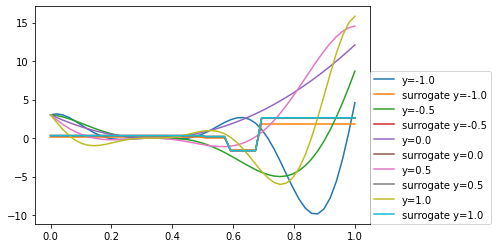

In [10]:
for y in np.linspace(-1, 1, 5):
    surrogate_predictions = optimizer.predict(pd.DataFrame({'x': line, 'y': y * np.ones(50)}),).get_dataframe()
    plt.plot(line, f(line, y), label=f"y={y}")
    plt.plot(line, surrogate_predictions.predicted_value, label=f"surrogate y={y}")
    plt.legend(loc=(1, 0))


We can run more iterations to improve the surrogate model and the optimum that is found:

In [11]:
# run for more iterations
n_iterations = 100
for i in range(n_iterations):
    run_optimization(optimizer)

{'x': 0.5429016621919669} -1.5297115102535705
{'x': 0.6815627236028251} -0.13877574065236475
{'x': 0.5936515343001382} 0.09197043015401835
{'x': 0.668508415014451} 2.07969706862827
{'x': 0.8372126245975092} 0.5516693020917062
{'x': 0.6435530815324457} -1.404392656297849
{'x': 0.724997192563687} 4.8732241120221
{'x': 0.5413769838772261} -1.0268410052426604
{'x': 0.31912561222421043} -0.006920119186832168
{'x': 0.6590415454025945} 3.777545491039695
{'x': 0.658852213147612} 1.1910905745205236
{'x': 0.6555420008381473} -2.1384304227994875
{'x': 0.2672002618261209} 0.14447504429369687
{'x': 0.657065174511078} -3.4738889955137733
{'x': 0.6564184283367182} 1.202776163160994
{'x': 0.657688766084161} -0.8387896810839808
{'x': 0.6484760517349945} -1.0910416840818609
{'x': 0.3481853166969554} -0.002480649997802783
{'x': 0.656252898129488} 1.9413618331154727
{'x': 0.8551741271792421} -8.464060307388461
{'x': 0.9429183811357548} -6.615396647754963
{'x': 0.6277165705799176} 3.1063733583638746
{'x': 

After more iterations, the slices reflect the true function much closer:

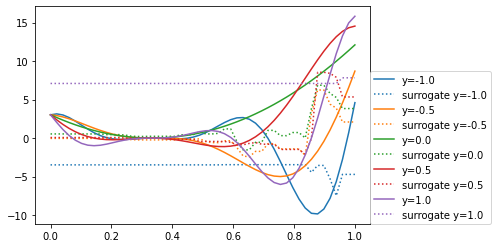

In [12]:
for y in np.linspace(-1, 1, 5):
    surrogate_predictions = optimizer.predict(pd.DataFrame({'x': line, 'y': y * np.ones(50)}),).get_dataframe()
    l, = plt.plot(line, f(line, y), label=f"y={y}")
    plt.plot(line, surrogate_predictions.predicted_value, linestyle=':', label=f"surrogate y={y}", c=l.get_color())
    plt.legend(loc=(1, 0))

Now, if we are given a new workload (i.e. some value of y), we can find the optimum setting of `x` for this workload:

In [13]:
optimizer.optimum(empirical=False, context=Point(y=0).to_dataframe())

{'x': 0.6258611230174319}

In [14]:
optimizer.optimum(empirical=False, context=Point(y=-1).to_dataframe())

{'x': 0.9351527603035865}